# Cross-Validation & Model Selection

**Business Question**: How do we reliably estimate model performance for restaurant tip prediction?

This notebook demonstrates k-fold cross-validation as a robust method for model selection, showing why it's better than single train-test splits and how to use it for choosing optimal model complexity.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand why single train-test splits are unreliable
- Implement k-fold cross-validation for robust model evaluation
- Compare different models using cross-validation
- Apply the one standard error rule for model selection
- Choose optimal model complexity using CV


In [11]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


In [12]:
# Load tips dataset
tips = sns.load_dataset('tips')

print("Dataset shape:", tips.shape)
print("\nFirst 5 rows:")
print(tips.head())

# Create dummy variables for categorical features
tips_encoded = pd.get_dummies(tips, columns=['sex', 'smoker', 'day', 'time'], drop_first=True)

# Prepare features and target
X = tips_encoded.drop('tip', axis=1)
y = tips_encoded['tip']

print(f"\nFeatures: {X.columns.tolist()}")
print(f"Target: {y.name}")
print(f"Number of features: {X.shape[1]}")


Dataset shape: (244, 7)

First 5 rows:
   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

Features: ['total_bill', 'size', 'sex_Female', 'smoker_No', 'day_Fri', 'day_Sat', 'day_Sun', 'time_Dinner']
Target: tip
Number of features: 8


## Problem with Single Train-Test Split


In [13]:
# Demonstrate the problem with single splits
np.random.seed(42)
single_split_scores = []

# Try multiple random splits
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # Simple model
    model = LinearRegression()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    single_split_scores.append(score)

print("Single Split Results (10 different random seeds):")
print("="*50)
for i, score in enumerate(single_split_scores):
    print(f"Split {i+1}: R² = {score:.4f}")

print(f"\nMean R²: {np.mean(single_split_scores):.4f}")
print(f"Std R²: {np.std(single_split_scores):.4f}")
print(f"Range: {np.max(single_split_scores) - np.min(single_split_scores):.4f}")

print("\nProblem: High variability in single splits!")
print("Solution: Use cross-validation for more robust estimates.")


Single Split Results (10 different random seeds):
Split 1: R² = 0.5545
Split 2: R² = 0.4876
Split 3: R² = 0.5621
Split 4: R² = 0.5246
Split 5: R² = 0.3338
Split 6: R² = -0.0342
Split 7: R² = 0.5027
Split 8: R² = 0.4770
Split 9: R² = 0.3558
Split 10: R² = 0.5089

Mean R²: 0.4273
Std R²: 0.1700
Range: 0.5963

Problem: High variability in single splits!
Solution: Use cross-validation for more robust estimates.


## K-Fold Cross-Validation Solution


Cross-Validation Results (5-fold):
Simple         : R² = 0.4214 ± 0.1353
Polynomial_2   : R² = 0.3091 ± 0.2024
Polynomial_3   : R² = -4.7805 ± 4.7536
Polynomial_4   : R² = -2522.6310 ± 3375.4717


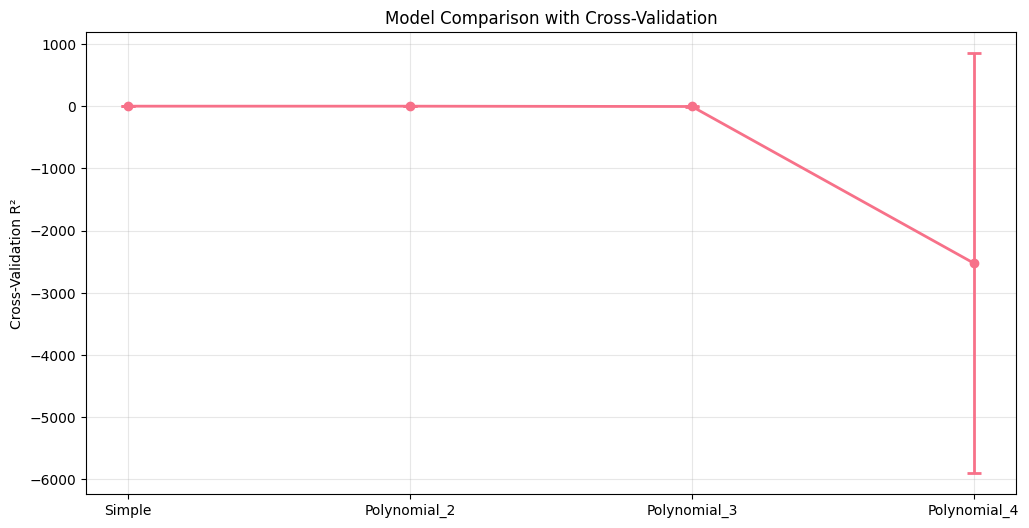


Best model: Simple
Best CV R²: 0.4214


In [14]:
# Build models of increasing complexity
models = {
    'Simple': LinearRegression(),
    'Polynomial_2': LinearRegression(),
    'Polynomial_3': LinearRegression(),
    'Polynomial_4': LinearRegression()
}

# Create polynomial features
poly2 = PolynomialFeatures(degree=2, include_bias=False)
poly3 = PolynomialFeatures(degree=3, include_bias=False)
poly4 = PolynomialFeatures(degree=4, include_bias=False)

X_poly2 = poly2.fit_transform(X)
X_poly3 = poly3.fit_transform(X)
X_poly4 = poly4.fit_transform(X)

# Prepare data for each model
model_data = {
    'Simple': X,
    'Polynomial_2': X_poly2,
    'Polynomial_3': X_poly3,
    'Polynomial_4': X_poly4
}

# Perform 5-fold cross-validation
cv_scores = {}
cv_std = {}

for name, model in models.items():
    X_data = model_data[name]
    scores = cross_val_score(model, X_data, y, cv=5, scoring='r2')
    cv_scores[name] = scores.mean()
    cv_std[name] = scores.std()

# Display results
print("Cross-Validation Results (5-fold):")
print("="*50)
for name in models.keys():
    print(f"{name:<15}: R² = {cv_scores[name]:.4f} ± {cv_std[name]:.4f}")

# Visualize results
plt.figure(figsize=(12, 6))
model_names = list(cv_scores.keys())
means = list(cv_scores.values())
stds = list(cv_std.values())

plt.errorbar(range(len(model_names)), means, yerr=stds, 
             marker='o', capsize=5, capthick=2, linewidth=2)
plt.xticks(range(len(model_names)), model_names)
plt.ylabel('Cross-Validation R²')
plt.title('Model Comparison with Cross-Validation')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nBest model: {max(cv_scores, key=cv_scores.get)}")
print(f"Best CV R²: {max(cv_scores.values()):.4f}")


## One Standard Error Rule


In [15]:
# Apply one standard error rule
best_score = max(cv_scores.values())
best_std = cv_std[max(cv_scores, key=cv_scores.get)]
one_se_threshold = best_score - best_std

print("One Standard Error Rule:")
print("="*40)
print(f"Best model score: {best_score:.4f}")
print(f"Best model std: {best_std:.4f}")
print(f"One SE threshold: {one_se_threshold:.4f}")

print("\nModels within one standard error:")
print("-" * 40)
for name, score in cv_scores.items():
    if score >= one_se_threshold:
        print(f"{name:<15}: R² = {score:.4f} ± {cv_std[name]:.4f} ✓")
    else:
        print(f"{name:<15}: R² = {score:.4f} ± {cv_std[name]:.4f} ✗")

# Find simplest model within one SE
valid_models = {name: score for name, score in cv_scores.items() if score >= one_se_threshold}

# Define model complexity order (simplest to most complex)
complexity_order = ['Simple', 'Polynomial_2', 'Polynomial_3', 'Polynomial_4']
valid_models_ordered = {name: score for name, score in valid_models.items() if name in complexity_order}

# Find the simplest valid model
simplest_model = None
for model_name in complexity_order:
    if model_name in valid_models_ordered:
        simplest_model = model_name
        break

print(f"\nRecommended model: {simplest_model}")
print("Reason: Simplest model within one standard error of best model")
print("This prevents overfitting to the CV procedure itself.")


One Standard Error Rule:
Best model score: 0.4214
Best model std: 0.1353
One SE threshold: 0.2861

Models within one standard error:
----------------------------------------
Simple         : R² = 0.4214 ± 0.1353 ✓
Polynomial_2   : R² = 0.3091 ± 0.2024 ✓
Polynomial_3   : R² = -4.7805 ± 4.7536 ✗
Polynomial_4   : R² = -2522.6310 ± 3375.4717 ✗

Recommended model: Simple
Reason: Simplest model within one standard error of best model
This prevents overfitting to the CV procedure itself.


## Key Takeaways

### **Cross-Validation Benefits:**

1. **Robust Estimates**: More reliable than single train-test splits
2. **Model Comparison**: Fair comparison of different models
3. **Overfitting Detection**: Identifies when models are too complex
4. **One SE Rule**: Prevents overfitting to CV procedure

### **When to Use Cross-Validation:**

- **Model selection** and comparison
- **Parameter tuning** and optimization
- **Feature selection** decisions
- **Any time** you need reliable performance estimates

### **Best Practices:**

- **Use k=5 or k=10** for most applications
- **Apply one standard error rule** for model selection
- **Always use CV** instead of single splits for model evaluation
